<a href="https://colab.research.google.com/github/Cado87/Hugging-Face-Computer-Vision-Course/blob/main/Feature_matching_LoFTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kornia  kornia-rs  kornia_moons opencv-python --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.1 MB/s eta 0:00:00


In [2]:
# Import libraries
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches

In [3]:
!wget https://github.com/opencv/opencv/raw/4.x/samples/data/box.png -O image1.png
!wget https://github.com/opencv/opencv/raw/4.x/samples/data/box_in_scene.png -O image2.png

--2025-11-10 19:30:35--  https://github.com/opencv/opencv/raw/4.x/samples/data/box.png
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/opencv/4.x/samples/data/box.png [following]
--2025-11-10 19:30:35--  https://raw.githubusercontent.com/opencv/opencv/4.x/samples/data/box.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50728 (50K) [image/png]
Saving to: ‘image1.png’

image1.png          100%[===================>]  49.54K  --.-KB/s    in 0.004s  

2025-11-10 19:30:35 (10.8 MB/s) - ‘image1.png’ saved [50728/50728]

--2025-11-10 19:30:35--  https://github.com/opencv/opencv/raw/4.x/sample

In [4]:
import cv2

img1_png = cv2.imread("image1.png")
img2_png = cv2.imread("image2.png")

cv2.imwrite("image1.jpg", img1_png)
cv2.imwrite("image2.jpg", img2_png)

True

In [5]:
#Load and resize the images.
from kornia.feature import LoFTR

img1 = K.io.load_image("image1.jpg", K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image("image2.jpg", K.io.ImageLoadType.RGB32)[None, ...]

img1 = K.geometry.resize(img1, (512, 512), antialias=True)
img2 = K.geometry.resize(img2, (512, 512), antialias=True)

In [6]:
#Indicate whether the image is an “indoor” or “outdoor” image.
matcher = LoFTR(pretrained="indoor")

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_indoor.ckpt" to /root/.cache/torch/hub/checkpoints/loftr_indoor.ckpt


100%|██████████| 44.2M/44.2M [00:00<00:00, 117MB/s]


In [7]:
#LoFTR only works on grayscale images, so convert to images to grayscale, if the are not.
input_dict = {}

if len(img1.shape) == 4 and img1.shape[1] == 3: # Check for (B, C, H, W) format and 3 channels
    input_dict["image0"] = K.color.rgb_to_grayscale(img1)
    print("Image 1 is in color")
else:
    input_dict["image0"] = img1 # If already grayscale, use the original image
    print("Image 1 is in gray")

if len(img2.shape) == 4 and img2.shape[1] == 3: # Check for (B, C, H, W) format and 3 channels
    input_dict["image1"] = K.color.rgb_to_grayscale(img2)
    print("Image 2 is in color")
else:
    input_dict["image1"] = img2 # If already grayscale, use the original image
    print("Image 2 is in grey")

Image 1 is in color
Image 2 is in color


In [8]:
#Let’s perform the inference
with torch.inference_mode():
    correspondences = matcher(input_dict)

In [9]:
#Clean up the correspondences using Random Sample Consensus (RANSAC). This helps to deal with noise or outliers in the data.
mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

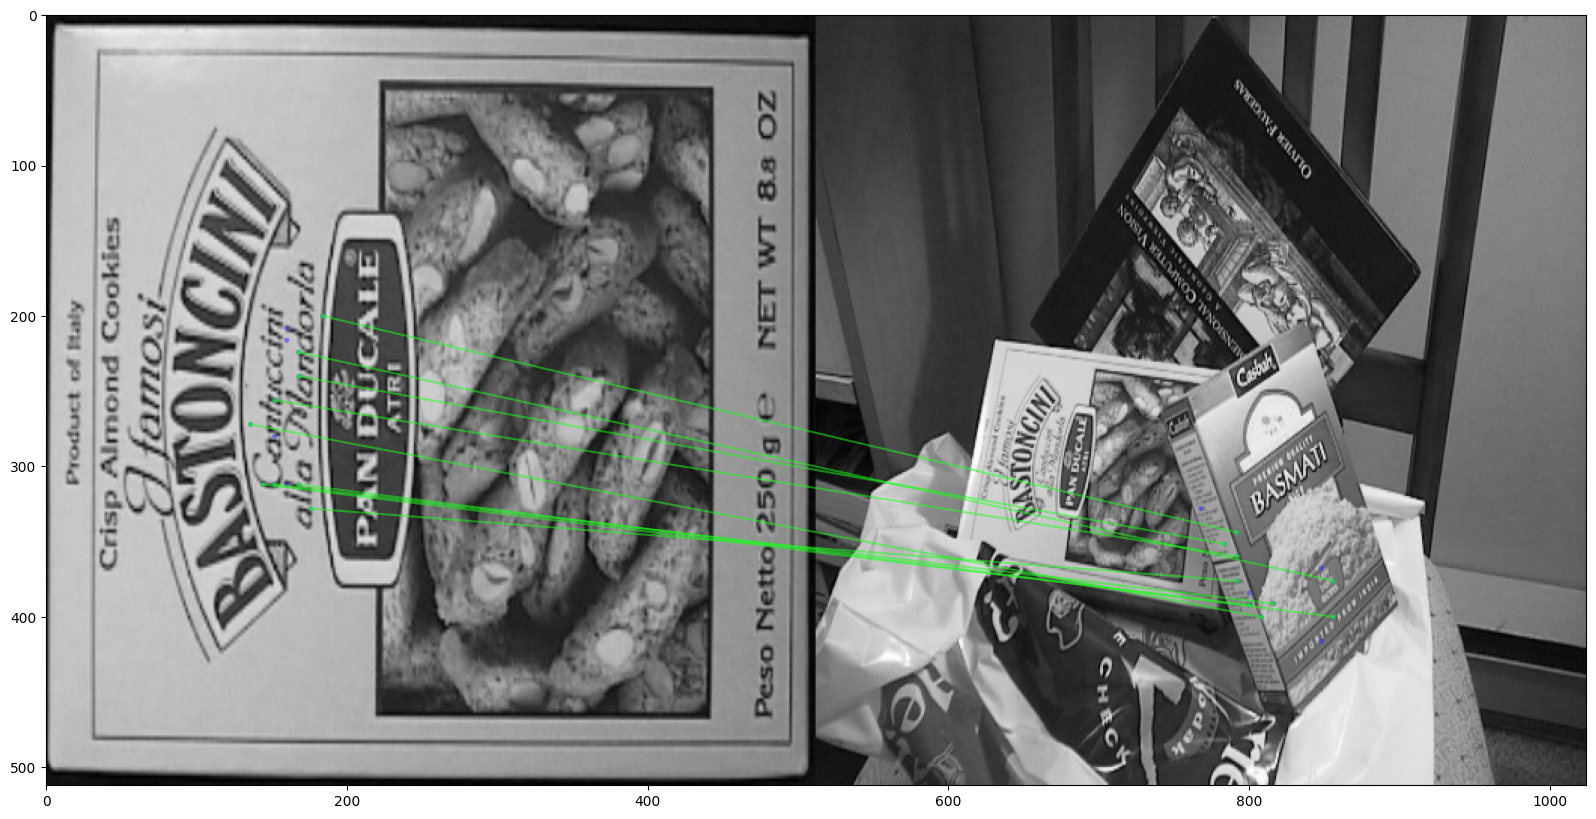

In [10]:
#Finally, we can visualize the matches.
draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={
        "inlier_color": (0.1, 1, 0.1, 0.5),
        "tentative_color": None,
        "feature_color": (0.2, 0.2, 1, 0.5),
        "vertical": False,
    },
)